In [24]:
%matplotlib inline
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from fashionai.data_util import extract_landmarks, scale_coordinates
from fashionai.data_util import ImageData, DataSequence, train_test_split
from fashionai.model import build_xception_model
from fashionai.loss import NormalizedError, SquareNormalizedError
from fashionai.utils import save_df_to_zip

In [2]:
DATA_DIR = '/workspace/ssd/fashionai/'
TRAIN_DATA_DIR = os.path.join(DATA_DIR, 'train')
TRAIN_ANNO_FILE = os.path.join(TRAIN_DATA_DIR, 'Annotations/train.csv')

# TEST_DATA_DIR = os.path.join(DATA_DIR, 'test')
TEST_DATA_DIR = os.path.join(DATA_DIR, 'testb')
TEST_ANNO_FILE = os.path.join(TEST_DATA_DIR, 'test.csv')

In [3]:
train_anno = pd.read_csv(TRAIN_ANNO_FILE)
test_anno = pd.read_csv(TEST_ANNO_FILE)

In [4]:
train_anno.head()

,image_id,image_category,neckline_left,neckline_right,center_front,shoulder_left,shoulder_right,armpit_left,armpit_right,waistline_left,...,top_hem_right,waistband_left,waistband_right,hemline_left,hemline_right,crotch,bottom_left_in,bottom_left_out,bottom_right_in,bottom_right_out
0,Images/blouse/3578977274375a7ab75862852210b5f5...,blouse,209_130_1,291_141_0,238_164_1,176_135_1,329_160_1,170_216_0,296_269_1,-1_-1_-1,...,280_380_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1
1,Images/blouse/524eb709a171eab14598860253023d62...,blouse,232_104_1,293_114_1,269_144_1,210_108_1,314_122_0,215_142_1,310_158_0,-1_-1_-1,...,322_255_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1
2,Images/blouse/72e09104ad0d46d59379b32197a14d64...,blouse,215_161_1,267_157_1,241_165_1,173_182_1,310_182_1,180_251_1,306_252_1,-1_-1_-1,...,307_398_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1
3,Images/blouse/ff068d86d60181edea224ffb16d1dbe8...,blouse,202_125_1,252_122_1,226_138_1,149_144_1,301_153_1,171_199_1,284_205_1,-1_-1_-1,...,276_337_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1
4,Images/blouse/d5def3258cee180b9af54505ecfaa2e0...,blouse,243_169_0,341_171_0,270_193_0,209_181_0,384_202_1,188_266_1,333_271_0,-1_-1_-1,...,384_464_1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1,-1_-1_-1


In [5]:
test_anno.head()

,image_id,image_category
0,Images/blouse/e21708ac483bc37679b26d064650bd40...,blouse
1,Images/blouse/6089d5c425308edaaf418a74c684a8fc...,blouse
2,Images/blouse/e6b066c5022da7666e1a0245b160f7a3...,blouse
3,Images/blouse/17eff8648aeceea2006d8ef9923e4722...,blouse
4,Images/blouse/e802cc5029e33753680e2937f8293a93...,blouse


把不存在归一化参数的样本丢弃，即不存在腋窝点的上衣、外套、连衣裙，不存在裤头的裤子和半身裙

In [6]:
NO_LANDMARK_SYM = '-1_-1_-1'

is_blouse = (train_anno.image_category == 'blouse')
is_outwear = (train_anno.image_category == 'outwear')
is_dress = (train_anno.image_category == 'dress')
is_trousers = (train_anno.image_category == 'trousers')
is_skirt = (train_anno.image_category == 'skirt')

no_armpit = ((train_anno.armpit_left == NO_LANDMARK_SYM) | (train_anno.armpit_right == NO_LANDMARK_SYM))
no_waistband = ((train_anno.waistband_left == NO_LANDMARK_SYM) | (train_anno.waistband_right == NO_LANDMARK_SYM))

bad_sample = ((is_blouse & no_armpit) | (is_dress & no_armpit) | (is_outwear & no_armpit) |
              (is_trousers & no_waistband) | (is_skirt & no_waistband))

In [7]:
print(np.sum(bad_sample), 'samples are without armpit or waistband.')
train_anno = train_anno.loc[~bad_sample]

136 samples are without armpit or waistband.


landmark 对应的编号

In [8]:
landmark_types = train_anno.columns.values[2:].tolist()
list(zip(range(len(landmark_types)), landmark_types))

[(0, 'neckline_left'),
 (1, 'neckline_right'),
 (2, 'center_front'),
 (3, 'shoulder_left'),
 (4, 'shoulder_right'),
 (5, 'armpit_left'),
 (6, 'armpit_right'),
 (7, 'waistline_left'),
 (8, 'waistline_right'),
 (9, 'cuff_left_in'),
 (10, 'cuff_left_out'),
 (11, 'cuff_right_in'),
 (12, 'cuff_right_out'),
 (13, 'top_hem_left'),
 (14, 'top_hem_right'),
 (15, 'waistband_left'),
 (16, 'waistband_right'),
 (17, 'hemline_left'),
 (18, 'hemline_right'),
 (19, 'crotch'),
 (20, 'bottom_left_in'),
 (21, 'bottom_left_out'),
 (22, 'bottom_right_in'),
 (23, 'bottom_right_out')]

将 category 信息变成整数，从 dataframe 中抽取 landmark 的坐标和可见性

In [9]:
img_cate_map = dict(zip(train_anno.image_category.unique(),  
                        range(train_anno.image_category.nunique())))
rev_img_cate_map = {v: k for k, v in img_cate_map.items()}

train_img_ids = train_anno.image_id.values
train_img_cats = train_anno.image_category.map(img_cate_map.get).values
train_landmark_pos, train_landmark_vis = extract_landmarks(train_anno.iloc[:, 2:].values)

test_img_ids = test_anno.image_id.values
test_img_cats = test_anno.image_category.map(img_cate_map.get).values

把不可见的点坐标全部设置为0，并转换到 `[0, 1]` 的区间中

In [10]:
SOURCE_SHAPE = (512, 512)
TARGET_SHAPE = (224, 224)

AS_GREY = False

train_landmark_pos[train_landmark_pos < 0] = 0
train_landmark_pos = scale_coordinates(train_landmark_pos, SOURCE_SHAPE, (1, 1))

In [11]:
train_imgs = ImageData(train_img_ids, TRAIN_DATA_DIR, normalize=False,
                       source_shape=SOURCE_SHAPE,
                       target_shape=TARGET_SHAPE, 
                       as_grey=AS_GREY)

test_imgs = ImageData(test_img_ids, TEST_DATA_DIR, normalize=False,
                      source_shape=SOURCE_SHAPE,
                      target_shape=TARGET_SHAPE, 
                      as_grey=AS_GREY)

In [12]:
def imshow(img, landmarks=None, landmark_coords=(1, 1)):
    cmap = 'gray' if img.shape[-1] == 1 else None
    img = img.squeeze()
    plt.imshow(img, cmap=cmap)
    if isinstance(landmarks, np.ndarray):
        xys = landmarks.reshape(-1, 2).copy()
        xys[:, 0] *= img.shape[0] / landmark_coords[0]
        xys[:, 1] *= img.shape[1] / landmark_coords[1]
        for p in xys:
            plt.scatter(p[0], p[1])

拿一个样本出来看看

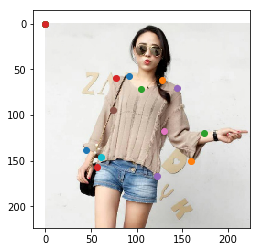

In [13]:
imshow(train_imgs[0], train_landmark_pos[0])

In [16]:
num_cat = len(img_cate_map)
num_lm = train_landmark_vis.shape[1]
input_shape = train_imgs.shape[1:]

model = build_xception_model(input_shape, num_cat, num_lm)
model.name = 'xception'
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 24)        120         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 24)           0           embedding_1[0][0]                
__________________________________________________________________________________________________
xception (

用来归一化的 landmark 坐标

In [18]:
landmark_normalizer_indices = [
    landmark_types.index('armpit_left'),
    landmark_types.index('armpit_right'),
    landmark_types.index('waistband_left'),
    landmark_types.index('waistband_right')
]
landmark_normalizer_indices

[5, 6, 15, 16]

用这些坐标构建 loss 函数

In [21]:
square_ne = SquareNormalizedError(landmark_normalizer_indices)
ne = NormalizedError(square_ne)

compile 模型

In [22]:
model.compile(optimizer='adam', loss=square_ne, metrics=[ne])

切分训练测试集，配置好 callbacks

- `TensorBoard` 可以记录训练的过程中 loss 的变化，方便你进行不同模型之间的对比
- `ModelCheckpoint` 可以把当前最好的模型给保存下来，如果中途中断训练，也方便后续把模型 load 回来
- `ReduceLROnPlateau` 当 loss 不再下降的时候，降低学习率
- `EarlyStopping` 当 loss 不再下降时，中断训练

因为有了 EarlyStopping 这个 callback，可以设置一个很大的 `epochs` 然后关掉显示器去干其他事情。实际情况下，
训练30-40个epochs左右模型会停下来，我用的是 `1080 Ti`，大约需要3-4个小时。

In [25]:
train_seq, val_seq = train_test_split([train_imgs, train_img_cats], train_landmark_pos,
                                      batch_size=16,
                                      num_samples=len(train_landmark_pos), 
                                      validation_split=0.1)

base_log_dir = './logs'
os.makedirs(base_log_dir, exist_ok=True)

log_dir = os.path.join(base_log_dir, model.name)
shutil.rmtree(log_dir, ignore_errors=True)
os.makedirs(log_dir, exist_ok=True)

model_save_path = os.path.join(log_dir, model.name + '.hdf5')

callbacks = [
    TensorBoard(log_dir, batch_size=train_seq.batch_size),
    ModelCheckpoint(model_save_path, monitor='val_ne', verbose=1, save_best_only=True),
    ReduceLROnPlateau('val_ne', factor=0.1, patience=3, verbose=1, mode='min'),
    EarlyStopping('val_ne', patience=5, mode='min')
]

In [ ]:
model.fit_generator(train_seq, 
                    epochs=100, 
                    callbacks=callbacks,
                    validation_data=val_seq,
                    workers=4, 
                    use_multiprocessing=True)

In [28]:
model.load_weights(model_save_path)

In [29]:
samples = val_seq[0][0]
preds = model.predict(samples, verbose=1)

16/16 [==============================] - 0s 27ms/step


大概看一下在验证集下的表现，这里是把所有点都显示出来了，因此会发现有一些点很飘，并不是预测错误，而是该图片中不存在这个 landmark，比如裤子的图片上是没有领口的landmark的

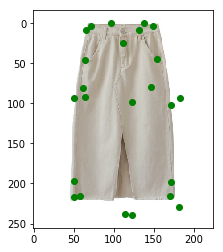

In [32]:
sample_id = np.random.randint(0, len(samples[0]))
sample_img = samples[0][sample_id].squeeze()
plt.imshow(sample_img, cmap='gray')
xys = preds[sample_id].reshape(-1, 2) * TARGET_SHAPE
plt.scatter(xys[:, 0], xys[:, 1], c='green')

对 test 数据进行预测

In [33]:
test_data = DataSequence([test_imgs, test_img_cats],
                         num_samples=len(test_imgs), 
                         batch_size=16,
                         shuffle=False)

In [34]:
preds = model.predict_generator(test_data, verbose=True, workers=4, use_multiprocessing=True)

624/624 [==============================] - 54s 87ms/step


肉眼看一下有没有严重 bug

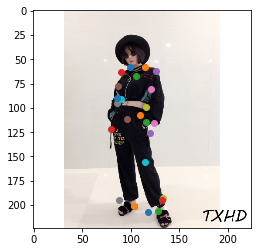

In [38]:
sample_id = np.random.randint(0, len(preds))
sample_img = test_imgs[sample_id]
imshow(sample_img, preds[sample_id])

输出答案，注意要把坐标点的范围从 [0, 1] 还原成 [0, 512]

In [39]:
preds = preds * 512

In [40]:
def make_submission(predictions, column_names=None):
    predictions = np.round(predictions).astype('int')
    predictions = np.clip(predictions, 0, 512)
    predictions = predictions.reshape(-1, 24, 2)
    res = []
    for lms in predictions:
        lms = ['{}_{}_1'.format(*lm) for lm in lms]
        res.append(lms)
    res = pd.DataFrame.from_records(res)
    res.columns = column_names
    return res

In [41]:
submit_df = make_submission(preds, train_anno.columns[2:])

In [42]:
submit_df = pd.concat([test_anno, submit_df], axis=1)

In [44]:
submit_df.head()

,image_id,image_category,neckline_left,neckline_right,center_front,shoulder_left,shoulder_right,armpit_left,armpit_right,waistline_left,...,top_hem_right,waistband_left,waistband_right,hemline_left,hemline_right,crotch,bottom_left_in,bottom_left_out,bottom_right_in,bottom_right_out
0,Images/blouse/e21708ac483bc37679b26d064650bd40...,blouse,148_85_1,271_83_1,210_138_1,117_104_1,301_101_1,126_195_1,297_190_1,131_268_1,...,319_391_1,140_115_1,330_118_1,117_405_1,352_432_1,240_321_1,255_433_1,135_409_1,265_462_1,362_427_1
1,Images/blouse/6089d5c425308edaaf418a74c684a8fc...,blouse,237_148_1,302_144_1,265_172_1,203_166_1,336_163_1,201_234_1,331_236_1,192_291_1,...,334_372_1,227_264_1,346_267_1,182_440_1,332_461_1,284_421_1,285_462_1,213_453_1,285_475_1,334_457_1
2,Images/blouse/e6b066c5022da7666e1a0245b160f7a3...,blouse,208_166_1,252_164_1,229_169_1,174_185_1,287_178_1,180_238_1,283_236_1,177_281_1,...,281_296_1,212_311_1,293_311_1,183_450_1,304_434_1,263_407_1,274_473_1,224_472_1,270_459_1,295_440_1
3,Images/blouse/17eff8648aeceea2006d8ef9923e4722...,blouse,140_77_1,256_41_1,218_67_1,95_130_1,322_54_1,145_231_1,348_163_1,179_322_1,...,393_315_1,176_157_1,369_103_1,192_476_1,446_425_1,326_408_1,352_480_1,229_487_1,373_461_1,445_416_1
4,Images/blouse/e802cc5029e33753680e2937f8293a93...,blouse,191_179_1,269_168_1,235_205_1,161_191_1,300_172_1,177_246_1,305_231_1,184_307_1,...,340_440_1,213_328_1,328_319_1,184_495_1,340_497_1,285_459_1,296_492_1,212_493_1,283_501_1,342_476_1


In [45]:
save_df_to_zip(submit_df, 'result.csv', index=False)